In [43]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd        


# ------------------ #
# Additional imports #
# ------------------ #
import random
import torch
import torch_geometric

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain
import torch.nn.functional as F


from torch import Tensor
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data 
from scipy.stats import ttest_ind

print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=mpl.MatplotlibDeprecationWarning)

Torch version: 2.5.1+cu124
Torch Geometric version: 2.6.1


In [44]:
RANDOM_STATE = 42
NUM_EPOCHS = 100

In [45]:
def set_seed_for_torch(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)      # For single-GPU.
        torch.cuda.manual_seed_all(seed)  # For multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def set_seed_for_numpy(seed):
    np.random.seed(seed) 
    
def set_seed_for_random(seed):
    random.seed(seed)

In [46]:
set_seed_for_torch(RANDOM_STATE)
set_seed_for_numpy(RANDOM_STATE)
set_seed_for_random(RANDOM_STATE)

In [47]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        
        correct = (pred[mask] == data.y[mask]).sum().item()
        accuracy = correct / mask.sum().item()

        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()

        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    return metrics

def predict(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
    return pred

def predict_probabilities(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        probabilities = torch.exp(out)
    return probabilities

In [48]:
def train_gnn(num_epochs, data, model, optimizer, criterion):
    
    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1_scores = []

    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    # ----- #
    # Train #
    # ----- #

    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], 
                         data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # --- Calculate training metrics ---
        pred_train = out[data.train_mask].argmax(dim=1)
        correct_train = (pred_train == data.y[data.train_mask]).sum()
        train_acc = int(correct_train) / int(data.train_mask.sum())
        train_accuracies.append(train_acc)

        y_true_train = data.y[data.train_mask].cpu().numpy()
        y_pred_train = pred_train.cpu().numpy()

        train_prec = precision_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_rec = recall_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted', zero_division=0)

        train_precisions.append(train_prec)
        train_recalls.append(train_rec)
        train_f1_scores.append(train_f1)
        train_losses.append(loss.item())

        # --- Validate and calculate validation metrics ---
        model.eval()
        with torch.no_grad():
            out = model(data)
            pred_val = out[data.val_mask].argmax(dim=1)
            correct_val = (pred_val == data.y[data.val_mask]).sum()
            val_acc = int(correct_val) / int(data.val_mask.sum())
            val_accuracies.append(val_acc)

            y_true_val = data.y[data.val_mask].cpu().numpy()
            y_pred_val = pred_val.cpu().numpy()

            val_prec = precision_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
            val_rec = recall_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
            val_f1 = f1_score(y_true_val, y_pred_val, average='weighted', zero_division=0)

            val_precisions.append(val_prec)
            val_recalls.append(val_rec)
            val_f1_scores.append(val_f1)

        if epoch % 10 == 0:        
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train - Acc: {train_acc:.4f} - Prec: {train_prec:.4f} - Rec: {train_rec:.4f} - F1: {train_f1:.4f}')
            print(f'                         Val   - Acc: {val_acc:.4f} - Prec: {val_prec:.4f} - Rec: {val_rec:.4f} - F1: {val_f1:.4f}')        

    return {
        'train': {
            'losses': train_losses,
            'accuracies': train_accuracies,
            'precisions': train_precisions,
            'recalls': train_recalls,
            'f1_scores': train_f1_scores,
        },
        'val': {
            'accuracies': val_accuracies,
            'precisions': val_precisions,
            'recalls': val_recalls,
            'f1_scores': val_f1_scores,            
        }
    }

In [49]:
def plot_train_val_test_metrics(train_val_metrics, test_metrics, num_epochs):
    plt.figure(figsize=(10, 6))

    # --- Accuracy ----
    plt.subplot(2, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['accuracies'], color='C0', linewidth=1.0, label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['accuracies'], color='C1', linewidth=1.0, label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['accuracy'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(fontsize=8)
    plt.title('Accuracy')

    # --- Precision ---
    plt.subplot(2, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['precisions'], color='C0', linewidth=1.0, label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['precisions'], color='C1', linewidth=1.0, label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['precision'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(fontsize=8)
    plt.title('Precision')

    # --- Recall ---
    plt.subplot(2, 2, 3)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['recalls'], color='C0', linewidth=1.0, label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['recalls'], color='C1', linewidth=1.0, label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['recall'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(fontsize=8)
    plt.title('Recall')

    # --- F1-Score ---
    plt.subplot(2, 2, 4)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['f1_scores'], linewidth=1.0, color='C0', label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['f1_scores'], linewidth=1.0, color='C1', label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['f1_score'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend(fontsize=8)
    plt.title('F1-Score')

    plt.tight_layout()
    plt.show()

In [12]:
elliptic_txs_features = pd.read_csv('./elliptic_txs_features.csv', header=None)
elliptic_txs_classes = pd.read_csv('./elliptic_txs_classes.csv')
elliptic_txs_edgelist = pd.read_csv('./elliptic_txs_edgelist.csv')

elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]

print(f"""Shapes
{4*' '}Features : {elliptic_txs_features.shape[0]:8,} (rows)  {elliptic_txs_features.shape[1]:4,} (cols)
{4*' '}Classes  : {elliptic_txs_classes.shape[0]:8,} (rows)  {elliptic_txs_classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {elliptic_txs_edgelist.shape[0]:8,} (rows)  {elliptic_txs_edgelist.shape[1]:4,} (cols)
""")

Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



In [16]:
elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

percentage_distribution = round(100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True), 2)
class_counts = elliptic_txs_classes['class_mapped'].value_counts()

emoji_mapping = {'licit': '✅', 'illicit': '❌', 'unknown': '🤷'}
elliptic_txs_classes['emoji'] = elliptic_txs_classes['class_mapped'].map(emoji_mapping)

classes_df = pd.DataFrame({
    'Class Mapped': elliptic_txs_classes['class_mapped'].unique(),
    'Class Raw': elliptic_txs_classes['class'].unique(),    
    'Counts': class_counts.values,
    'Percentage': percentage_distribution.values,
    'Emoji': [emoji_mapping[class_label] for class_label in elliptic_txs_classes['class_mapped'].unique()]
})
classes_df

,Class Mapped,Class Raw,Counts,Percentage,Emoji
0,unknown,unknown,157205,77.15,🤷
1,licit,2,42019,20.62,✅
2,illicit,1,4545,2.23,❌


In [17]:
num_nodes = elliptic_txs_features.shape[0]
num_edges = elliptic_txs_edgelist.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

Number of nodes: 203,769
Number of edges: 234,355


In [18]:
# Create graph from the edgelist.
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, 'txId1', 'txId2')

In [19]:
# Sampling for easier analysis...for now.
classes_sampled = elliptic_txs_classes.groupby('class_mapped').sample(frac=0.05, random_state=RANDOM_STATE)
txIds_sampled = classes_sampled['txId']

# Filter elliptic_txs_edgelist based on the sampled txIds
edgelist_sampled = elliptic_txs_edgelist[
    elliptic_txs_edgelist['txId1'].isin(txIds_sampled) | elliptic_txs_edgelist['txId2'].isin(txIds_sampled)
]

# Filter elliptic_txs_features based on the sampled txIds
features_sampled = elliptic_txs_features[elliptic_txs_features['txId'].isin(txIds_sampled)]

print(f"Sampled Classes:\n{classes_sampled['class_mapped'].value_counts()}\n")
print(f"Sampled Edgelist: {edgelist_sampled.shape[0]:,}")
print(f"Sampled Features: {features_sampled.shape[0]:,}")

Sampled Classes:
unknown    7860
licit      2101
illicit     227
Name: class_mapped, dtype: int64

Sampled Edgelist: 23,051
Sampled Features: 10,188


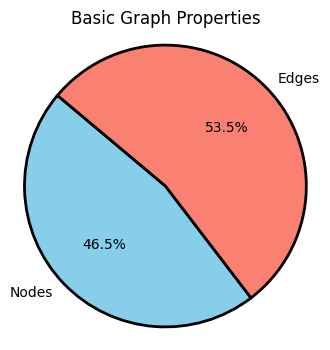

In [20]:
plt.figure(figsize=(4, 4))
sizes = [num_nodes, num_edges]
labels = ['Nodes', 'Edges']
colors = ['skyblue', 'salmon']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, 
        wedgeprops = {'edgecolor' : 'black', 
                      'linewidth': 2, 
                      'antialiased': True})
plt.title('Basic Graph Properties')
plt.axis('equal')
plt.show()

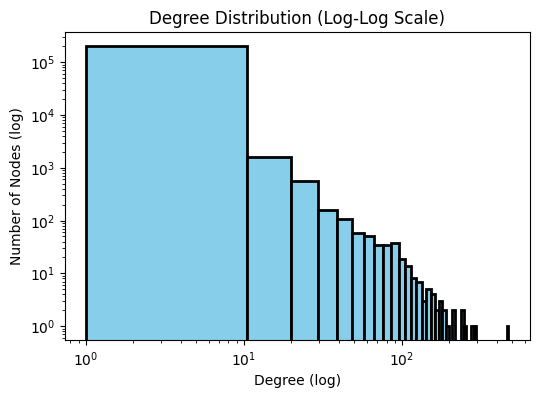

In [21]:
# --- Degree Distribution (Log-Log Scale) ---
plt.figure(figsize=(6, 4))
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black', linewidth=2.0)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (log)')
plt.ylabel('Number of Nodes (log)')
plt.show()

Number of nodes: 10,188
Number of edges: 23,051


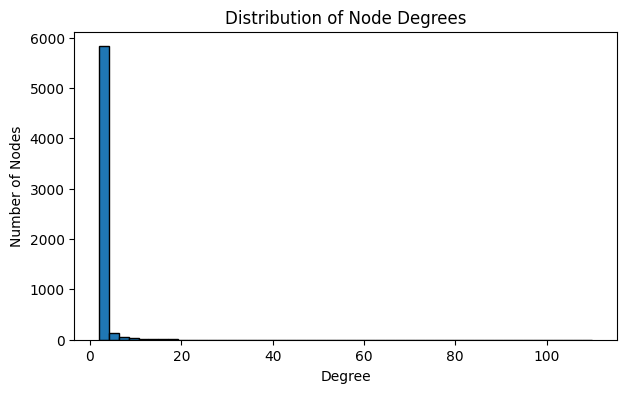

In [22]:
# Number of nodes and edges
num_nodes = features_sampled.shape[0]
num_edges = edgelist_sampled.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

# Distribution of node degrees
plt.figure(figsize=(7, 4))

node_degrees = edgelist_sampled['txId1'].value_counts() + edgelist_sampled['txId2'].value_counts()
node_degrees.hist(bins=50, edgecolor='black')
plt.title('Distribution of Node Degrees')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.grid(False)
plt.show()

In [23]:
# Create graph from the edgelist.
G = nx.from_pandas_edgelist(edgelist_sampled, 'txId1', 'txId2')

Number of connected components: 7297
Giant component - Number of nodes: 400
Giant component - Number of edges: 431


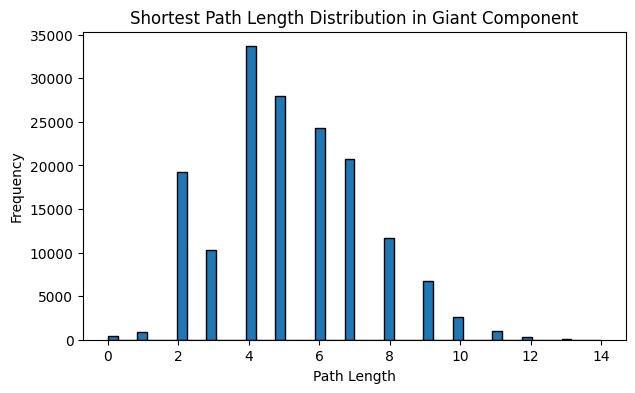

In [24]:
# --- Connected components ---
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

# --- Giant component analysis ---
giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")


# --------------------------------------------------------- #
# Shortest paths length distribution in the giant component #
# --------------------------------------------------------- #
path_lengths = dict(nx.shortest_path_length(G_giant))
path_lengths_values = [length for target_lengths in path_lengths.values() for length in target_lengths.values()]

plt.figure(figsize=(7, 4))
plt.hist(path_lengths_values, bins=50, edgecolor='black')
plt.title('Shortest Path Length Distribution in Giant Component')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.show()

Top 10 nodes by degree centrality:
        Node  Degree Centrality
0   22837965           0.275689
1   22837835           0.192982
2  279199578           0.030075
3    3807285           0.027569
4  279187194           0.027569
5   22837973           0.022556
6   90716926           0.022556
7    8128388           0.022556
8   22837808           0.020050
9   22838007           0.020050


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

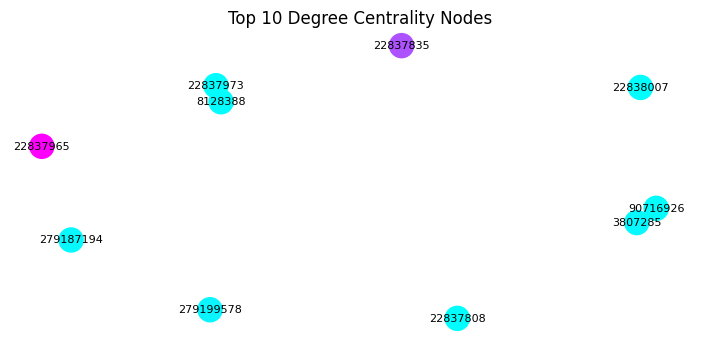

In [26]:
# Degree centrality.
degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_degree_centrality = pd.DataFrame(top_degree_centrality, columns=['Node', 'Degree Centrality'])

print("Top 10 nodes by degree centrality:")
print("==================================")
print(df_top_degree_centrality)

top_nodes_by_ = df_top_degree_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [degree_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
plt.figure(figsize=(7, 3))

nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap)
plt.title('Top 10 Degree Centrality Nodes')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Degree Centrality')
plt.show()

Top 10 nodes by betweenness centrality:
        Node  Betweenness Centrality
0   22837835                0.553959
1   22837965                0.491607
2   90716926                0.166458
3   22837784                0.165590
4  279187194                0.164591
5    3807285                0.144993
6    3097782                0.113509
7    8128388                0.103709
8    1435388                0.092219
9   21296808                0.086872


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

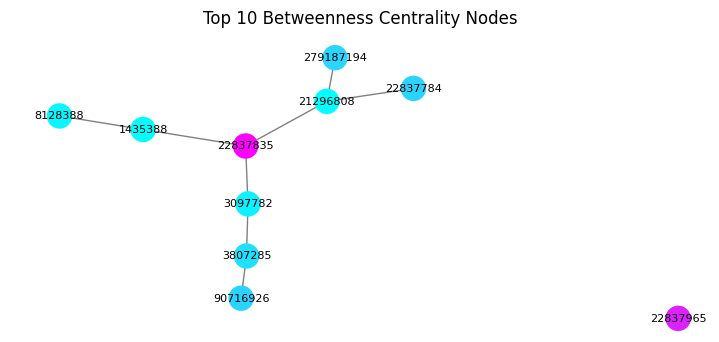

In [27]:
# Betweenness centrality.
betweenness_centrality = nx.betweenness_centrality(G_giant)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

print("Top 10 nodes by betweenness centrality:")
print("=======================================")
print(df_top_betweenness_centrality)

top_nodes_by_ = df_top_betweenness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [betweenness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
plt.figure(figsize=(7, 3))

nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap)
plt.title('Top 10 Betweenness Centrality Nodes')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Betweenness Centrality')
plt.show()

Top 10 nodes by closeness centrality:
        Node  Closeness Centrality
0   22837835              0.317928
1   22837965              0.293814
2    2203811              0.290605
3    1805107              0.285817
4   11447640              0.285817
5    2205152              0.285817
6    1367537              0.285817
7    1437191              0.285817
8   21296808              0.274038
9  279187194              0.271613


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

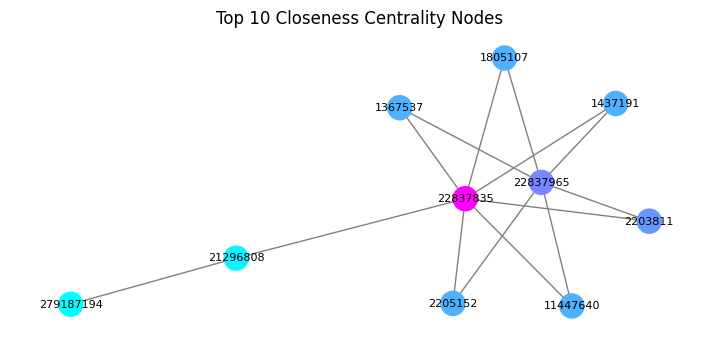

In [28]:
# Closeness centrality.
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_closeness_centrality = pd.DataFrame(top_closeness_centrality, columns=['Node', 'Closeness Centrality'])

print("Top 10 nodes by closeness centrality:")
print("=====================================")
print(df_top_closeness_centrality)

top_nodes_by_closeness = df_top_closeness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_closeness)
node_color = [closeness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
plt.figure(figsize=(7, 3))

nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap)
plt.title('Top 10 Closeness Centrality Nodes')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Closeness Centrality')
plt.show()

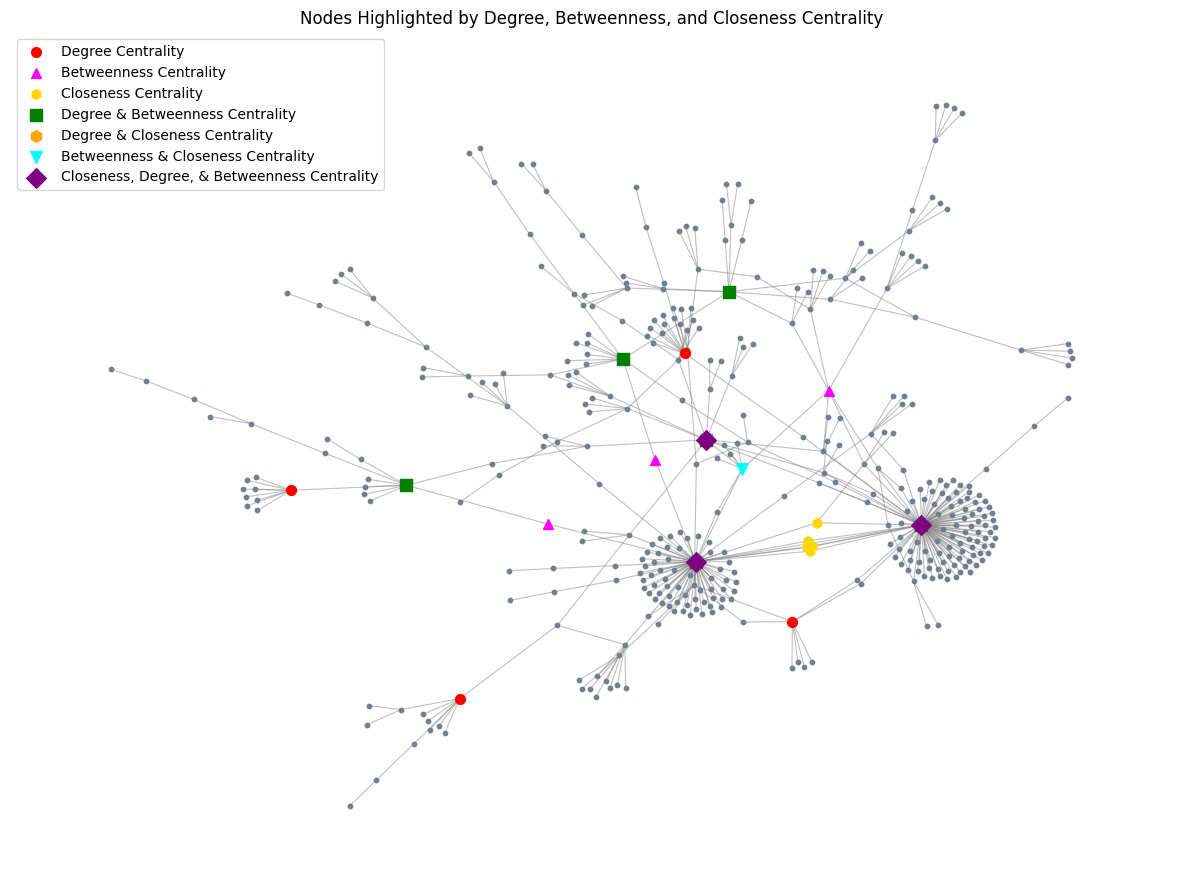

In [29]:
# --------- #
# Preparing #
# --------- #

# Identify nodes that are top in each centrality measure and their combinations.
top_nodes_degree = set([node for node, _ in top_degree_centrality])
top_nodes_betweenness = set([node for node, _ in top_betweenness_centrality])
top_nodes_closeness = set([node for node, _ in top_closeness_centrality])

top_nodes_both = top_nodes_degree.intersection(top_nodes_betweenness)
top_nodes_closeness_and_degree = top_nodes_closeness.intersection(top_nodes_degree)
top_nodes_closeness_and_betweenness = top_nodes_closeness.intersection(top_nodes_betweenness)
top_nodes_all_three = top_nodes_closeness.intersection(top_nodes_degree).intersection(top_nodes_betweenness)

# Assign colors and shapes based on centrality measures.
node_color = []
node_shape = []

for node in G_giant.nodes():
    if node in top_nodes_all_three:
        node_color.append('purple')
        node_shape.append('D')
    elif node in top_nodes_closeness_and_degree:
        node_color.append('orange')
        node_shape.append('h')
    elif node in top_nodes_closeness_and_betweenness:
        node_color.append('cyan')
        node_shape.append('v')
    elif node in top_nodes_both:
        node_color.append('green')
        node_shape.append('s')
    elif node in top_nodes_degree:
        node_color.append('red')
        node_shape.append('o')
    elif node in top_nodes_betweenness:
        node_color.append('magenta')
        node_shape.append('^')
    elif node in top_nodes_closeness:
        node_color.append('yellow')
        node_shape.append('h')
    else:
        node_color.append('slategrey')
        node_shape.append('o')

# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(15, 11))

pos = nx.spring_layout(G_giant)
# Draw all nodes first.
nx.draw_networkx_nodes(G_giant, pos, node_color='slategrey', node_size=10)

# Draw nodes with specific centrality measures.
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_degree - top_nodes_both - top_nodes_closeness_and_degree), 
                       node_color='red', node_size=50, node_shape='o', 
                       label='Degree Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_betweenness - top_nodes_both - top_nodes_closeness_and_betweenness), 
                       node_color='magenta', node_size=50, node_shape='^', 
                       label='Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness - top_nodes_closeness_and_degree - top_nodes_closeness_and_betweenness), 
                       node_color='gold', node_size=50, node_shape='h', 
                       label='Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_both), 
                       node_color='green', node_size=80, node_shape='s', 
                       label='Degree & Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_degree), 
                       node_color='orange', node_size=70, node_shape='h', 
                       label='Degree & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_betweenness), 
                       node_color='cyan', node_size=70, node_shape='v', 
                       label='Betweenness & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_all_three), 
                       node_color='purple', node_size=100, node_shape='D', 
                       label='Closeness, Degree, & Betweenness Centrality')

# Draw edges.
nx.draw_networkx_edges(G_giant, pos, width=0.8, edge_color='gray', alpha=0.5)

plt.axis('off')
plt.title('Nodes Highlighted by Degree, Betweenness, and Closeness Centrality')
plt.legend(scatterpoints=1)
plt.show()